In [1]:
from typing import Dict, Union

import torch

from deepfloyd_if.pipelines import dream
from deepfloyd_if.modules import T5Embedder, IFStageI
from deepfloyd_if.finetune.adapter import inject_adapter
from deepfloyd_if.finetune.adapter_diffusion import add_vtokens

/home/jiaqiguo/miniconda3/envs/deepfloyd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-07-05 03:16:33,464] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
FORCE_MEM_EFFICIENT_ATTN= 0 @UNET:QKVATTENTION

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/jiaqiguo/miniconda3/envs/deepfloyd/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda111.so
CUDA SETUP: CUDA runtime path found: /home/v-xinyuzhu/local/bin/cuda111/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 111
CUDA SETUP: Loading binary /home/jiaqiguo/miniconda3/envs/deepfloyd/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda111.so...


/home/jiaqiguo/miniconda3/envs/deepfloyd/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /home/jiaqiguo/miniconda3/envs/deepfloyd did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


In [2]:
DEVICE = "cuda:0"
NUM_VTOKENS = 1

BOTTLENECK_R = 2
BOTTLENECK_CHANNELS = 4
ADAPTER_SCALE = 1.0
SHARE_ADAPTER = False

In [3]:
t5 = T5Embedder(device="cpu", torch_dtype=torch.float32, use_offload_folder=None)
vtoken_seq, vtoken_ids = add_vtokens(t5, num_tokens=NUM_VTOKENS, init_token=None)

/home/jiaqiguo/miniconda3/envs/deepfloyd/lib/python3.8/site-packages/huggingface_hub/file_download.py:1104: FutureWarning: The `force_filename` parameter is deprecated as a new caching system, which keeps the filenames as they are on the Hub, is now in place.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.72s/it]


VToken ids: [32100]


In [4]:
if_I = IFStageI('IF-I-XL-v1.0', device=DEVICE, model_kwargs={"precision": 32})
if_I.model.to(dtype=if_I.model.dtype)

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=704, out_features=2816, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2816, out_features=2816, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 704, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 704, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Conv2d(704, 704, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): GELU(approximate='none')
          (1): Linear(in_features=2816, out_features=1408, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 704, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Dropout(p

In [5]:
def basic_test(t5, if_I, if_II, prompt: str, seed: int = 42) -> None:
    init_result = dream(
        t5=t5, if_I=if_I, if_II=if_II,
        prompt=[prompt],
        seed=seed,
        if_I_kwargs={
            "guidance_scale": 7.0,
            "sample_timestep_respacing": "smart100",
        },
    )
    if_I.show(init_result['I'], size=16)
    if if_II is not None:
        if_II.show(init_result['II'] , size=16)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


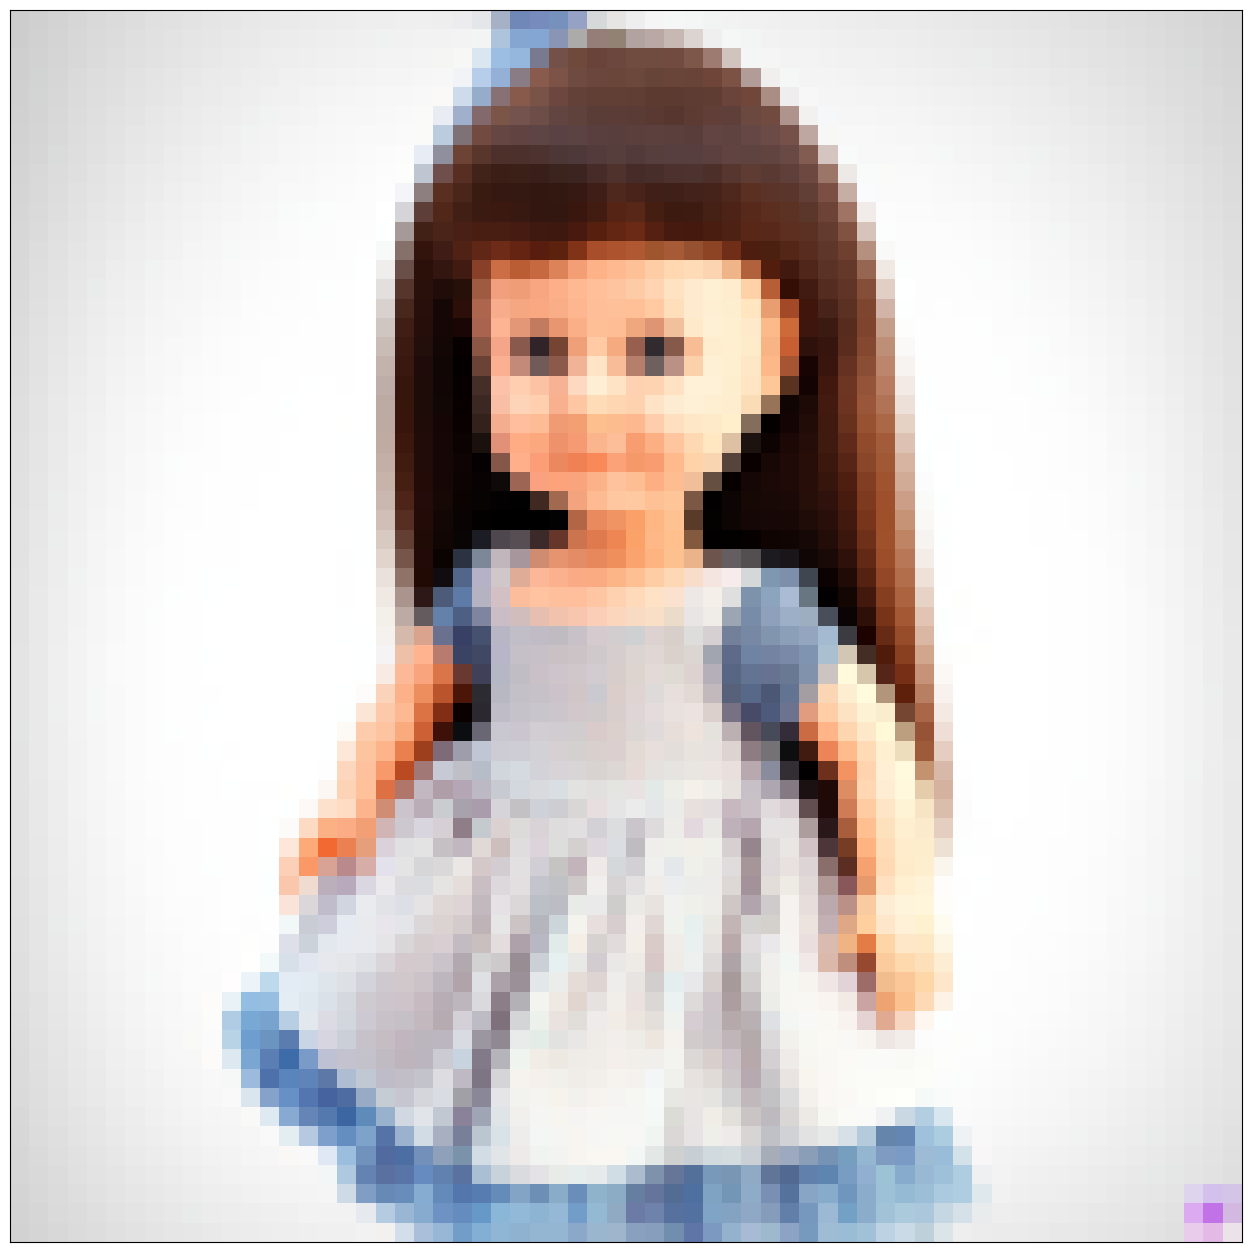

In [6]:
basic_test(t5, if_I, None, "a photo of a  doll, white background")

In [7]:
inject_adapter(if_I.model, BOTTLENECK_R, BOTTLENECK_CHANNELS, ADAPTER_SCALE, SHARE_ADAPTER)

INFO:deepfloyd_if.finetune.adapter:Name: input_blocks-1408, Adapter-Down: 1408, Bottleneck: 4, Up: 1408, Shared: False
INFO:deepfloyd_if.finetune.adapter:Name: input_blocks-1408, Adapter-Down: 1408, Bottleneck: 4, Up: 1408, Shared: False
INFO:deepfloyd_if.finetune.adapter:Name: input_blocks-1408, Adapter-Down: 1408, Bottleneck: 4, Up: 1408, Shared: False
INFO:deepfloyd_if.finetune.adapter:Name: input_blocks-2112, Adapter-Down: 2112, Bottleneck: 4, Up: 2112, Shared: False
INFO:deepfloyd_if.finetune.adapter:Name: input_blocks-2112, Adapter-Down: 2112, Bottleneck: 4, Up: 2112, Shared: False
INFO:deepfloyd_if.finetune.adapter:Name: input_blocks-2112, Adapter-Down: 2112, Bottleneck: 4, Up: 2112, Shared: False
INFO:deepfloyd_if.finetune.adapter:Name: input_blocks-2816, Adapter-Down: 2816, Bottleneck: 4, Up: 2816, Shared: False
INFO:deepfloyd_if.finetune.adapter:Name: input_blocks-2816, Adapter-Down: 2816, Bottleneck: 4, Up: 2816, Shared: False
INFO:deepfloyd_if.finetune.adapter:Name: input_b

[<generator object Module.parameters at 0x7fa93517a7b0>,
 <generator object Module.parameters at 0x7fa93517a890>,
 <generator object Module.parameters at 0x7fa93517af90>,
 <generator object Module.parameters at 0x7fa93517ab30>,
 <generator object Module.parameters at 0x7fa93517ac10>,
 <generator object Module.parameters at 0x7fa93517ad60>,
 <generator object Module.parameters at 0x7fa93517add0>,
 <generator object Module.parameters at 0x7fa93517aeb0>,
 <generator object Module.parameters at 0x7fa4725230b0>,
 <generator object Module.parameters at 0x7fa472523120>,
 <generator object Module.parameters at 0x7fa472523270>,
 <generator object Module.parameters at 0x7fa472523350>,
 <generator object Module.parameters at 0x7fa472523430>,
 <generator object Module.parameters at 0x7fa472523510>,
 <generator object Module.parameters at 0x7fa4725235f0>,
 <generator object Module.parameters at 0x7fa4725236d0>,
 <generator object Module.parameters at 0x7fa4725237b0>,
 <generator object Module.param

In [8]:
if_I.model.to(DEVICE).eval()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=704, out_features=2816, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2816, out_features=2816, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 704, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 704, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Conv2d(704, 704, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): GELU(approximate='none')
          (1): Linear(in_features=2816, out_features=1408, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 704, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Dropout(p

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


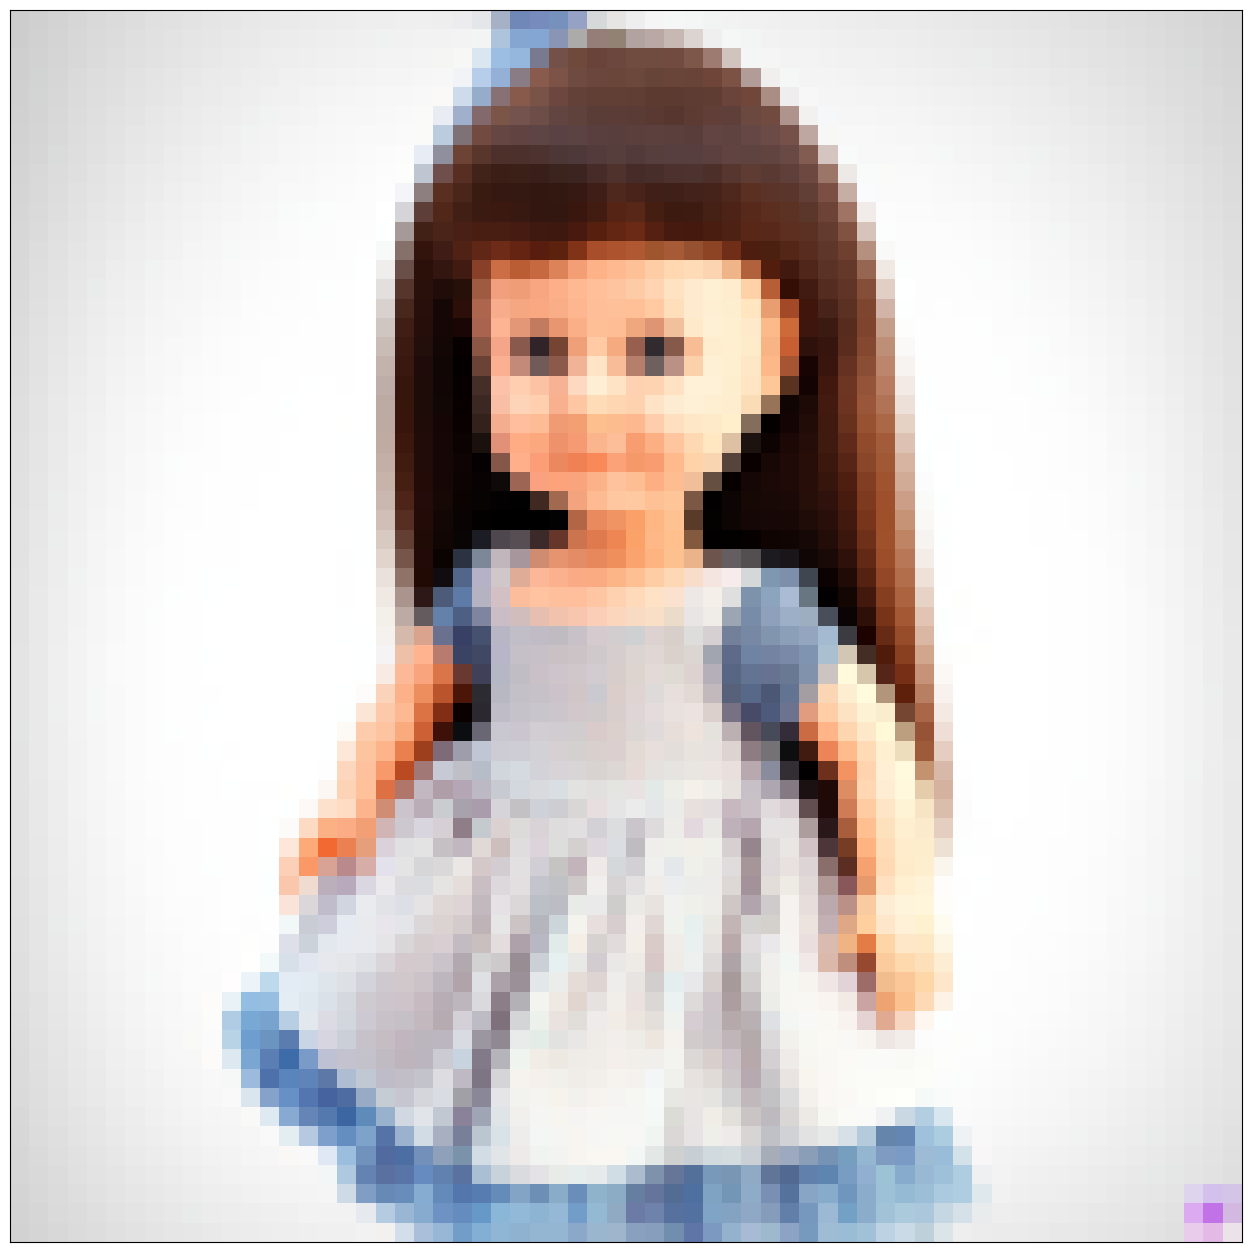

In [9]:
basic_test(t5, if_I, None, "a photo of a  doll, white background", seed=42)

In [10]:
def load_vtoken_embeds(t5: T5Embedder, ckpt: Union[Dict, str]) -> None:
    if isinstance(ckpt, str):
        _ckpt = torch.load(ckpt)
    else:
        _ckpt = ckpt
    token_embeds = t5.model.get_input_embeddings().weight.data
    for vid, vembed in _ckpt.items():
        token_embeds[vid] = vembed.to(t5.model.device)

        
def load_unet_ckpt(if_I: IFStageI, ckpt_path: str) -> None:
    state = torch.load(ckpt_path)
    if_I.model = state
    

def set_adapter_scale(if_I: IFStageI, scale: float) -> None:
    for fullname, module in if_I.model.named_modules():
        if module.__class__.__name__ == "AdapterAttentionBlock":
            module.adapter_scale = scale

In [11]:
CKPT_PATH = "/data/jiaqi/if_ckpts/adapter_diffusion_bottleneck_channels_4/unet-step-10000.bin"
load_unet_ckpt(if_I, CKPT_PATH)

In [12]:
load_vtoken_embeds(t5, CKPT_PATH.replace(".bin", "-embeds.bin"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


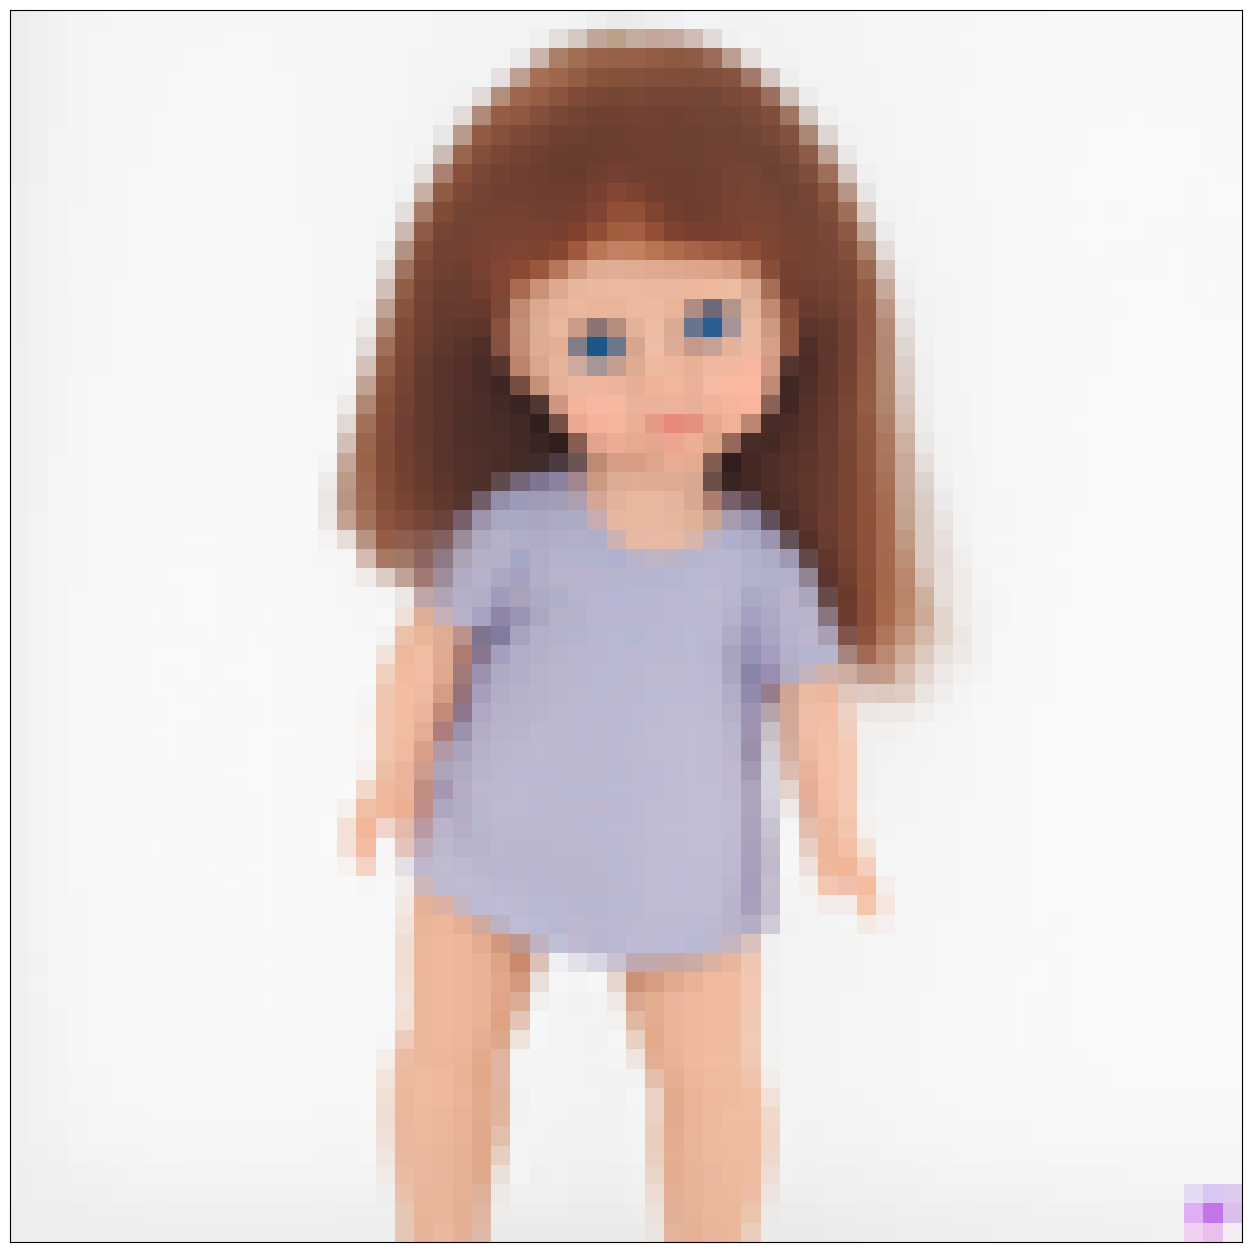

In [13]:
basic_test(t5, if_I, None, "a photo of a sks doll, white background")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


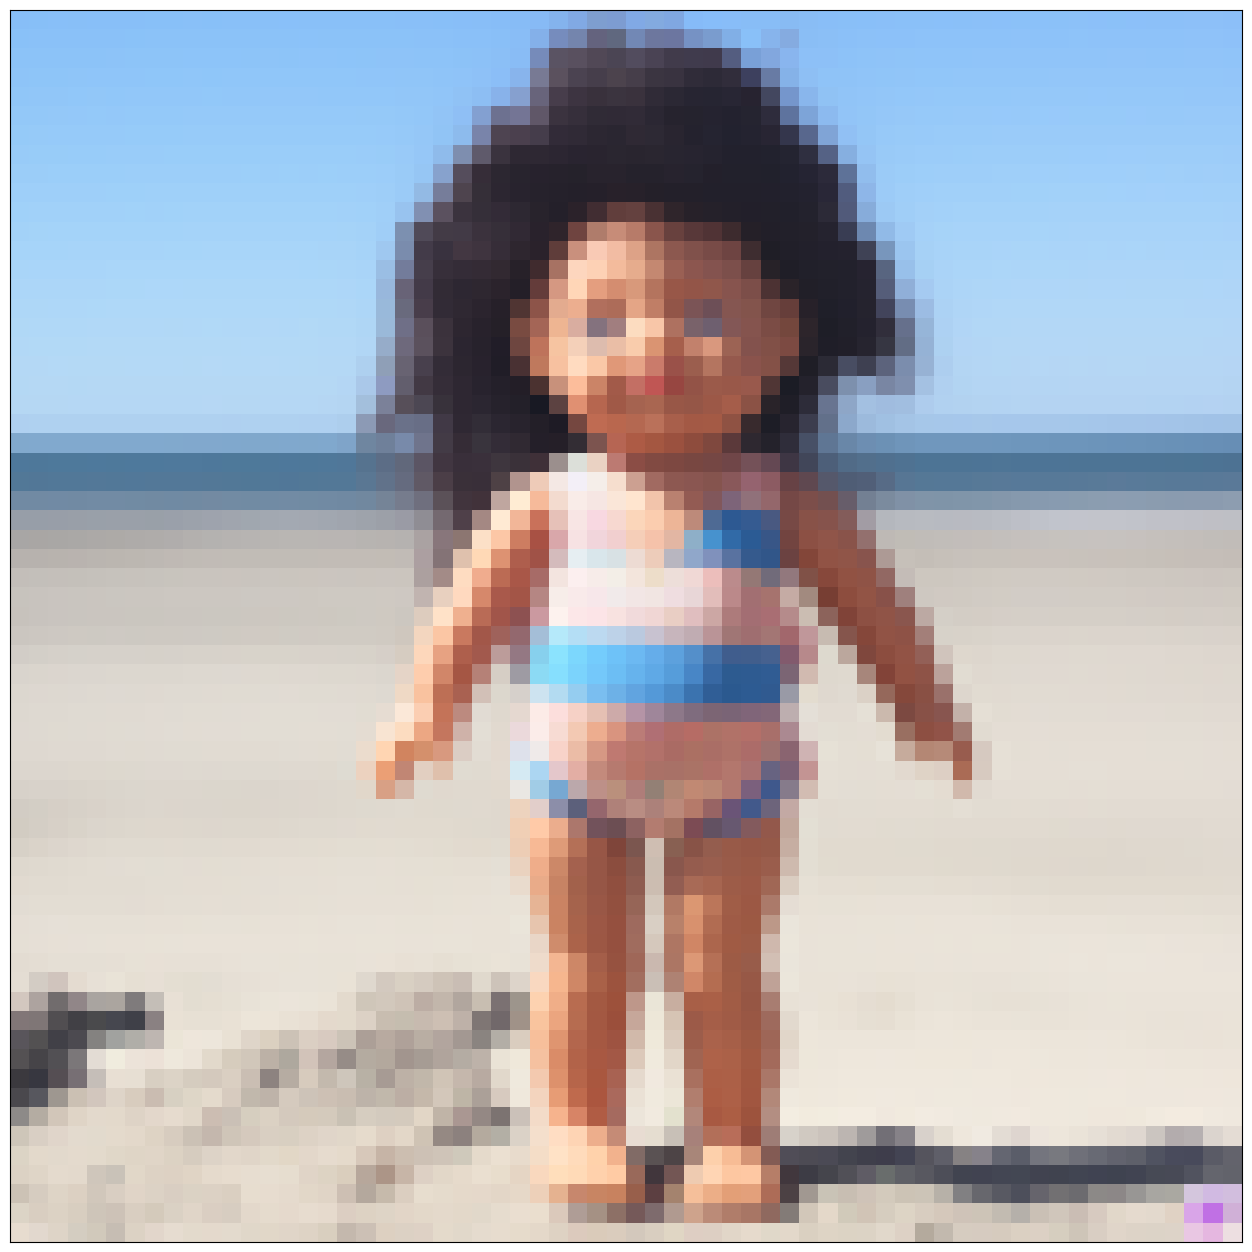

In [14]:
basic_test(t5, if_I, None, "a photo of a sks doll at the beach")

In [33]:
set_adapter_scale(if_I, 1.2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


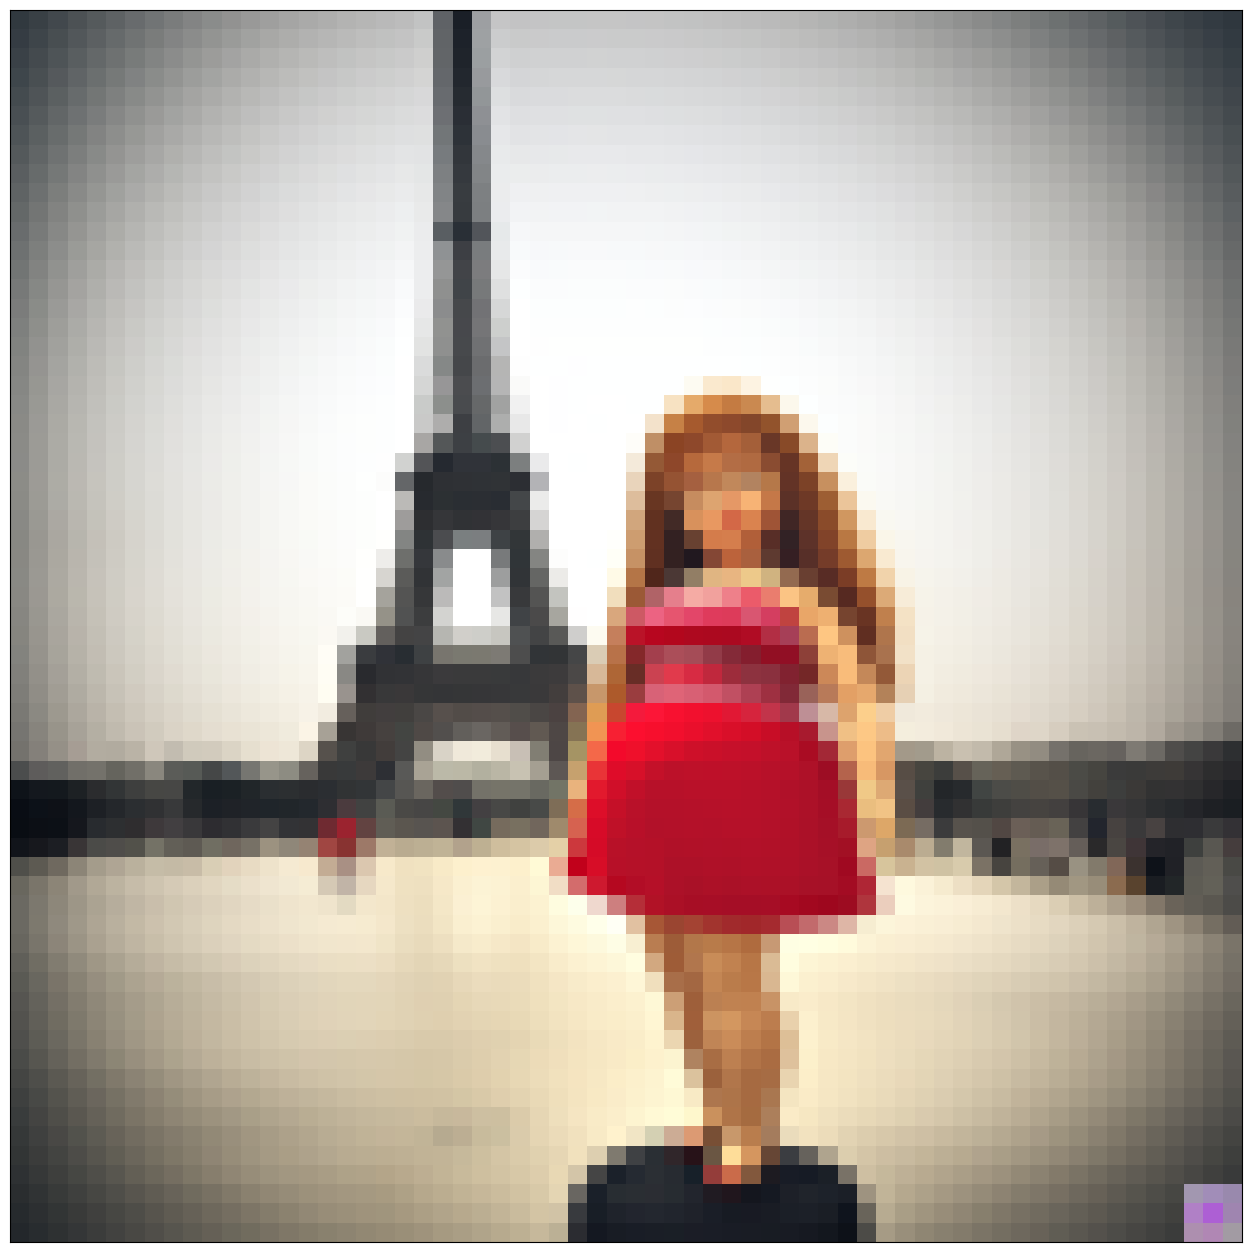

In [34]:
basic_test(t5, if_I, None, "a photo of a sks doll at Paris")

In [27]:
set_adapter_scale(if_I, 0.0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


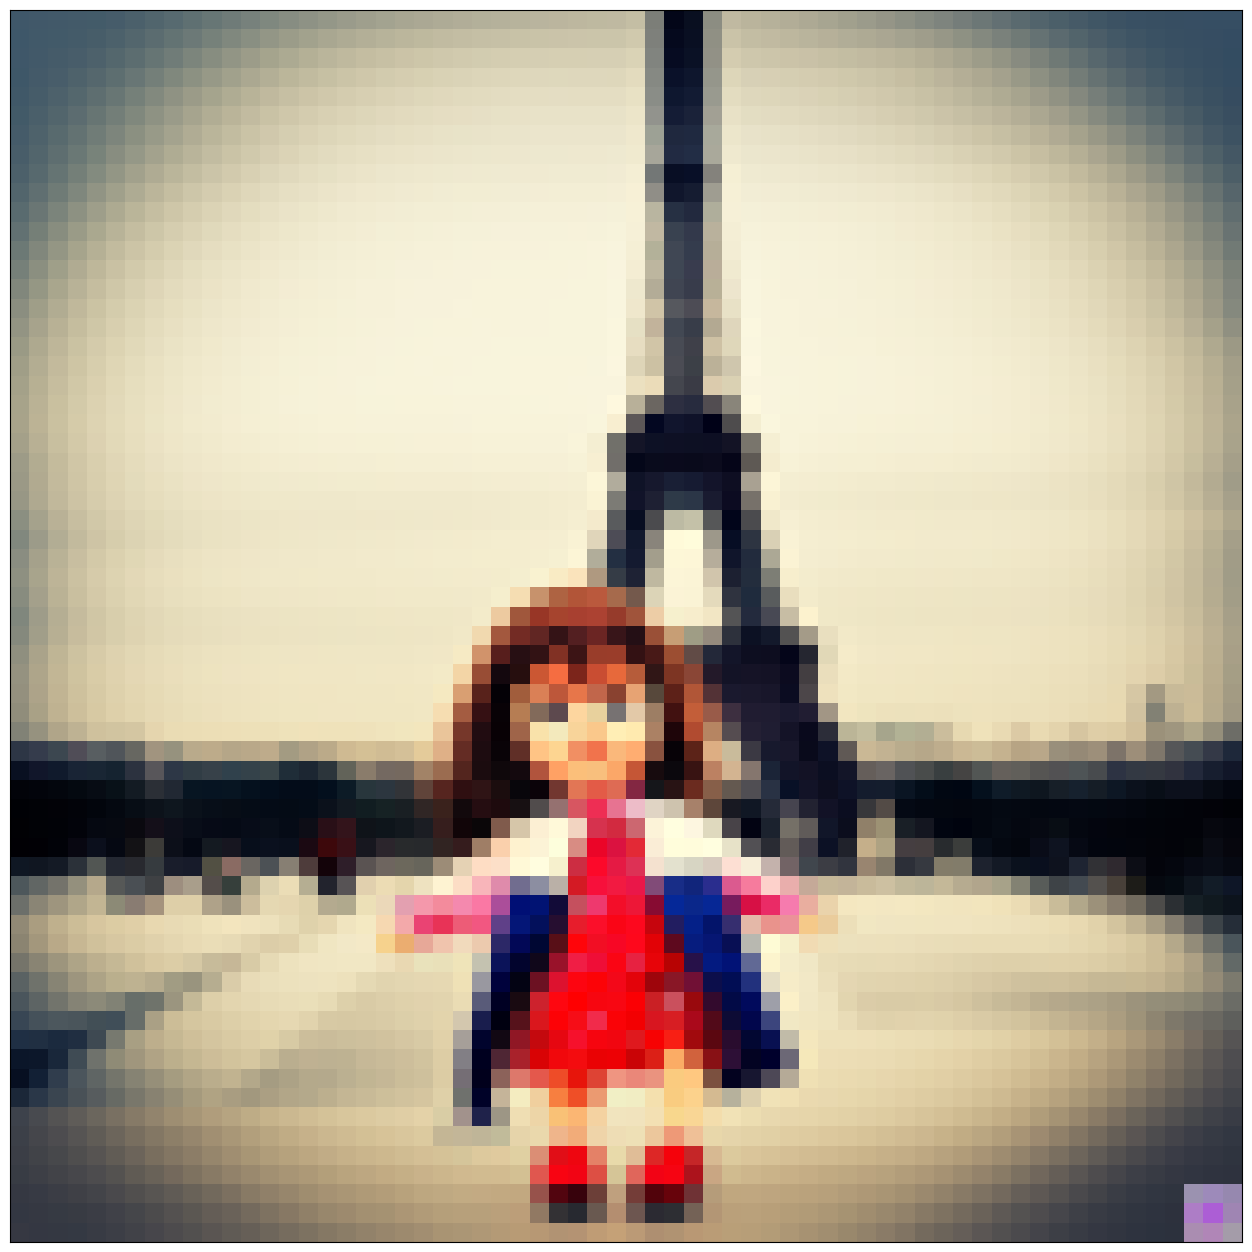

In [28]:
basic_test(t5, if_I, None, "a photo of a sks doll in front of Effiel Tower")